In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First, we imported the dataset, which was obtained from [Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [ ]:
import numpy as np
import pandas as pd

data = pd.read_csv("/content/drive/My Drive/Final Project/Tweets.csv")

In [2]:
#local start from here

import numpy as np
import pandas as pd

data = pd.read_csv("/Users/baihuiyu/Desktop/Final Project/Tweets.csv")

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


This dataset contains Tweets about airlines, and a sentiment of positive, negative, or neutral for each Tweet. In this project, we will attempt to categorize the Tweets into these categories, and will do so using some pre-trained sentiment analysis packages, TextBlob and VaderSentiment, as well as by training some algorithms based on this specific data, Naive Bayes and Random Forest classifiers. 

First, we will do some basic exploration of the data, such as the prior probabilities of each class.

In [ ]:
class_probs = (data['airline_sentiment'].value_counts()/data['airline_sentiment'].count())
class_probs

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

In [ ]:
labels = "negative", "neutral", "positive"
values = [class_probs[0], class_probs[1], class_probs[2]]

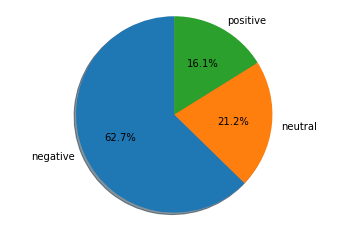

In [ ]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
pd.crosstab(data['airline'],data['airline_sentiment'],margins = True) 

airline_sentiment,negative,neutral,positive,All
airline,,,,
American,1960,463,336,2759
Delta,955,723,544,2222
Southwest,1186,664,570,2420
US Airways,2263,381,269,2913
United,2633,697,492,3822
Virgin America,181,171,152,504
All,9178,3099,2363,14640


First, we will start wth VaderSentiment. Vader stands for Valence Aware Dictionary and sEntiment Reasoner. According to VaderSentiment's [package documentation](https://github.com/cjhutto/vaderSentiment), Vader 'is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.' The tool is designed specifically to understand social media texts, for example, it understands emoticons such as ':)' which people may include in these types of posts.

The Vader sentiment analysis provides 4 scores: positive, negative, neutral, and compound. The positive, negative, and neutral scores indicate the proportion of the text that falls into each of the respective categories. The most useful score, though, is the compound score. This is a normalized score indicating the overal polarity of the text. In general, a score between -0.05 and 0.05 is considered neutral, and anything greater in absolute value than 0.05 can be categorized as either positive or negative.

We wrote the function vader_sentiment() to return a sentiment of positive, negative or neutral based on this rule.

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [ ]:
def vader_sentiment(text): 
  
    sid_obj = SentimentIntensityAnalyzer() 
    analysis = sid_obj.polarity_scores(text)
    if analysis['compound'] > 0.05:
      return 'positive'
    elif analysis['compound'] < -0.05:
      return 'negative'
    else:
      return 'neutral'

Next, we wrote a function to apply vader_sentiment() to every Tweet in the dataset.

In [ ]:
def pred_vader(row):
    prediction = vader_sentiment(row['text'])
    return prediction

In [ ]:
data['vader_prediction'] = data.apply (lambda row: pred_vader(row), axis=1)

You can see the inclusion of the vader_prediction column below. 

In [ ]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,textblob_prediction,vader_prediction
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),neutral,neutral
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),neutral,neutral
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),negative,neutral
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),positive,negative
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),negative,negative


Next, we created a confusion matrix based on the actual class of the data and the predicted class by VaderSentiment. 

In [ ]:
confusion = confusion_matrix(data['airline_sentiment'], data['vader_prediction'])
confusion

array([[4033, 1427, 3718],
       [ 363,  989, 1747],
       [  68,  145, 2150]])

The accuracy utilizing this pre-trained tool is 48.99%.

In [ ]:
total_correct = confusion[0][0]+confusion[1][1]+confusion[2][2]
total = confusion[0][0]+confusion[0][1]+confusion[0][2]+confusion[1][0]+confusion[1][1]+confusion[1][2]+confusion[2][0]+confusion[2][1]+confusion[2][2]
accuracy = total_correct/total
accuracy

0.48989071038251364

Next, we will attempt the same classification problem using a different pre-trained classification tool to see if the accuracy is higher. Specifically, we will utilize the TextBlob package. The [TextBlob](https://textblob.readthedocs.io/en/dev/) function returns a single polarity score for each Tweet. If the polarity score is positive (> 0.05), we can classify the Tweet as positive. If it is negative (< 0.05), we can classify the Tweet as negative. In the case that the polarity score is between -0.05 and 0.05 , we can classify the Tweet as neutral. Therefore, we wrote a function that will do exactly this.

In [ ]:
from textblob import TextBlob

In [ ]:
def textblob_sentiment(text):
        analysis = TextBlob(text)
        if analysis.sentiment.polarity > 0.05:
            return 'positive'
        elif analysis.sentiment.polarity < -0.05:
            return 'negative'
        else:
            return 'neutral'

We defined a function called pred_textblob() which returns the sentiment for each row in the dataset using the textblob_sentiment function.

In [ ]:
def pred_textblob(row):
    prediction = textblob_sentiment(row['text'])
    return prediction

Next, we created a new column in the dataframe to capture the prediction from TextBlob. This column is visible in the head of the dataframe, which is printed below. 

In [ ]:
data['textblob_prediction'] = data.apply (lambda row: pred_textblob(row), axis=1)

In [ ]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,textblob_prediction,vader_prediction
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),neutral,neutral
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),neutral,neutral
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),negative,neutral
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),neutral,negative
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),negative,negative


We wanted to create a confusion matrix in order to check the accuracy of the classification done by TextBlob.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion = confusion_matrix(data['airline_sentiment'], data['textblob_prediction'])
confusion

array([[2962, 3798, 2418],
       [ 287, 1847,  965],
       [  82,  490, 1791]])

Using the confusion matrix, we computed that the accuracy was only around 45.08%.

In [ ]:
total_correct = confusion[0][0]+confusion[1][1]+confusion[2][2]
total = confusion[0][0]+confusion[0][1]+confusion[0][2]+confusion[1][0]+confusion[1][1]+confusion[1][2]+confusion[2][0]+confusion[2][1]+confusion[2][2]
accuracy = total_correct/total
accuracy

0.45081967213114754

Vader is better.

Lastly, we will also try to train our own model, with Naive Bayes. Training our own model will likely lead to a higher accuracy because it will be trained specifically on the airline Tweets, versus the pre-trained models which were trained more generally on unrelated text data. 

Naive Bayes works to calculate the probability of each class given the words contained in the Tweet, and then chooses the most likely class: 

$argmax P(class|features)$

To calculate the probability of each class given the words contained in the Tweet, it utilizes Bayes' Rule, which states:

$P(class|features) = \frac{P(class)*P(features|class)}{P(features)}$

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In order to learn the probabilities required for the Bayes' Rule classification, we will use 75% of the Tweets in the dataset as the training data, and the remaining 25% as test data in order to determine the classifier's accuracy. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['airline_sentiment'], random_state = 0)

We converted the text of the Tweets into feature vectors based on the words that they contain. First, we simply created a count matrix. Then, we transformed it using tf-idf scores.

In [ ]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)

Note that after completing this, the X_train is a sparse matrix, containing 10,980 rows (number of Tweets) and 12,758 columns (number of words in the vocabulary). 

In [ ]:
X_train_tfidf

<10980x12758 sparse matrix of type '<class 'numpy.float64'>'
	with 175552 stored elements in Compressed Sparse Row format>

Then, we trained the Naive Bayes model using the training data.

In [ ]:
nb = MultinomialNB()
nb = nb.fit(X_train_tfidf, y_train)

In [ ]:
nb = MultinomialNB()
nb = nb.fit(X_train_counts, y_train)

The accuracy is higher using Naive Bayes than the pre-trained models, around 67.46%.

In [ ]:
nb.score(X_test_tfidf, y_test)

0.6745901639344263

In [ ]:
nb.score(X_test_counts, y_test)

0.7740437158469945

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Lastly, we trained one final model on the specific Tweets: a random forest classifier. We used the same training and testing data from the Naive Bayes model, including the tf-idf matrix. By default, the number of trees is 100.

In [ ]:
rf = RandomForestClassifier()
rf = rf.fit(X_train_tfidf, y_train)

In [ ]:
rf = RandomForestClassifier()
rf = rf.fit(X_train_counts, y_train)

Using all of the random forest's default parameters, we obtained the highest accuracy yet of 75.74%. This accuracy could potentially be even further improved by fine-tuning the parameters of the model.

In [ ]:
rf.score(X_test_tfidf, y_test)

0.7573770491803279

In [ ]:
rf.score(X_test_counts, y_test)

0.7562841530054645